# Data Cleaning and EDA

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-e3a2e3055c28>:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
df = pd.read_csv('data/data.csv', encoding = 'unicode_escape')

In [3]:
df.rename(columns={'tweet_text':'Tweet','emotion_in_tweet_is_directed_at':'Product',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'Sentiment'}, inplace=True)

In [4]:
df.dropna(subset=['Tweet'],inplace=True)
df.drop_duplicates(inplace=True)
df['Product'].fillna('Unknown',inplace=True)

In [5]:
sentiment_list=[]
for i in df['Sentiment']:
    if (i=="No emotion toward brand or product")|(i=="I can't tell"):
        sentiment_list.append('Neutral')
    elif i=='Positive emotion':
        sentiment_list.append('Positive')
    elif i=='Negative emotion':
        sentiment_list.append('Negative')
df['Sentiment']=sentiment_list

In [6]:
df['Sentiment'].value_counts()

Neutral     5531
Positive    2970
Negative    569 
Name: Sentiment, dtype: int64

In [7]:
neg_ornot=[]
for i in df['Sentiment']:
    if (i=='Neutral')|(i=='Positive'):
        neg_ornot.append('Non-Negative')
    elif i=='Negative':
        neg_ornot.append('Negative')
df['Sentiment']=neg_ornot

In [8]:
df['Sentiment']

0       Negative    
1       Non-Negative
2       Non-Negative
3       Negative    
4       Non-Negative
            ...     
9088    Non-Negative
9089    Non-Negative
9090    Non-Negative
9091    Non-Negative
9092    Non-Negative
Name: Sentiment, Length: 9070, dtype: object

In [9]:
df['Product'].value_counts()

Unknown                            5788
iPad                               945 
Apple                              659 
iPad or iPhone App                 469 
Google                             428 
iPhone                             296 
Other Google product or service    293 
Android App                        80  
Android                            77  
Other Apple product or service     35  
Name: Product, dtype: int64

In [10]:
google_values = 'google','android'
apple_values = 'apple','iphone','ipad'
def brand_classification(Product, Tweet):
    brand='Unknown'
    if (Product.lower().__contains__('google'))|(Product.lower().__contains__('android')):
        brand = 'Google'
    elif (Product.lower().__contains__('apple'))|(Product.lower().__contains__('iphone'))|(Product.lower().__contains__('ipad')):
        brand = 'Apple'
    if (brand == 'Unknown'):
        lowercase_tweet = Tweet.lower()
        google = (lowercase_tweet.__contains__('google'))|(lowercase_tweet.__contains__('android'))
        apple = (lowercase_tweet.__contains__('iphone'))|(lowercase_tweet.__contains__('ipad'))|(lowercase_tweet.__contains__('apple'))
        if (google & apple):
            brand = 'Both'
        elif apple:
            brand = 'Apple'
        elif google:
            brand = 'Google'
    return brand
                
df['Brand'] = df.apply(lambda row: brand_classification(row['Product'], row['Tweet']), axis=1)
df['Brand'].value_counts()

Apple      5341
Google     2789
Unknown    759 
Both       181 
Name: Brand, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9070 non-null   object
 1   Product    9070 non-null   object
 2   Sentiment  9070 non-null   object
 3   Brand      9070 non-null   object
dtypes: object(4)
memory usage: 354.3+ KB


In [12]:
def tweet_cleaner(tweet):
    twtr_stopwords = ['rt','rts','retweet','quot','sxsw', 'amp']
    punctuation = set(string.punctuation)
    punctuation.remove('#')
    
    x=tweet
    x=re.sub(r'https?:\/\/\S+', '', x) #remove URLs
    x=re.sub(r'{link}', '', x) #placeholders
    x=re.sub(r'@[\w]*', '', x) #@mention users
    x=re.sub('[^A-Za-z0-9]+', ' ', x) #@mention users
    x=re.sub(r'\b[0-9]+\b', '', x) #remove stand-alone numbers
    x=re.sub(r'&[a-z]+;', '', x) #remove HTML ref chars
    x=re.sub(r'\d+', '', x) #removes all NUMERALS
    x=''.join(ch for ch in x if ch not in punctuation) #remove punctuation
    x=x.replace("[^a-zA-z#]", " ") #remove special chars
    
    x=[word.lower() for word in x.split() if word.lower() not in twtr_stopwords]
    x=[w for w in x if len(w)>2]
    
    return ' '.join(x)
    

In [13]:
df['Cleaned_Tweet'] = df['Tweet'].map(lambda x: tweet_cleaner(x))

In [14]:
df['Cleaned_Tweet']

0       have iphone after hrs tweeting rise austin was dead need upgrade plugin stations                                             
1       know about awesome ipad iphone app that you likely appreciate for its design also they giving free                           
2       can not wait for ipad also they should sale them down                                                                        
3       hope this year festival isn crashy this year iphone app                                                                      
4       great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress                              
                                                     ...                                                                             
9088    ipad everywhere                                                                                                              
9089    wave buzz interrupt your regularly scheduled geek prog

In [15]:
df.head()

,Tweet,Product,Sentiment,Brand,Cleaned_Tweet
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Non-Negative,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Non-Negative,Apple,can not wait for ipad also they should sale them down
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Non-Negative,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress


In [16]:
stopwords_list = stopwords.words('english')
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)
stemmer = PorterStemmer()

In [17]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    text_tokens = tokenizer.tokenize(text)

    text_tokens_stopped = [word for word in text_tokens if word not in stopwords_list]
    
    final_text = [stemmer.stem(token) for token in text_tokens_stopped]
    
    return final_text

In [18]:
text_data = df.Cleaned_Tweet.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

In [19]:
df["Preprocessed_Text"] = text_data
df.head()

,Tweet,Product,Sentiment,Brand,Cleaned_Tweet,Preprocessed_Text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations,"[iphon, hr, tweet, rise, austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Non-Negative,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free,"[know, awesom, ipad, iphon, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Non-Negative,Apple,can not wait for ipad also they should sale them down,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app,"[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Non-Negative,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, matt, mullenweg, wordpress]"


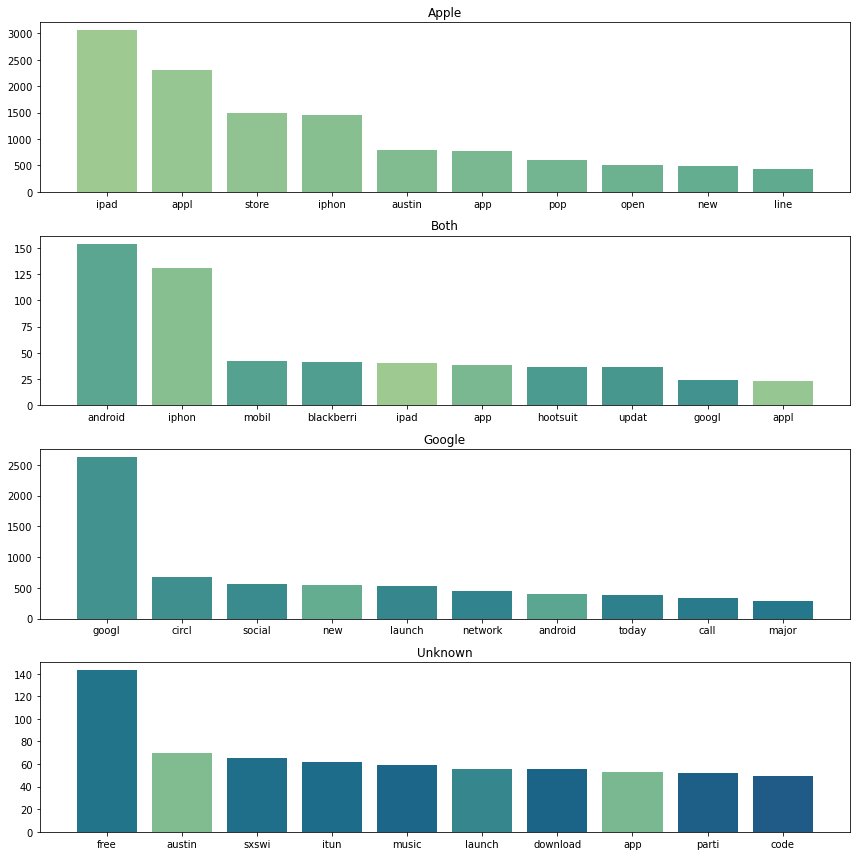

In [20]:
# Run this cell without changes
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and axes
fig, axes = plt.subplots(nrows=4, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('crest', n_colors=38)

# Creating a plot for each unique genre
data_by_brand = [y for _, y in df.groupby('Brand', as_index=False)]
for idx, brand_df in enumerate(data_by_brand):
    # Find top 10 words in this genre
    all_words_in_genre = brand_df.Preprocessed_Text.explode()
    top_10 = all_words_in_genre.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(brand_df.iloc[0].Brand.title())
    
fig.tight_layout()

In [21]:
df.head()

,Tweet,Product,Sentiment,Brand,Cleaned_Tweet,Preprocessed_Text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,have iphone after hrs tweeting rise austin was dead need upgrade plugin stations,"[iphon, hr, tweet, rise, austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Non-Negative,Apple,know about awesome ipad iphone app that you likely appreciate for its design also they giving free,"[know, awesom, ipad, iphon, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Non-Negative,Apple,can not wait for ipad also they should sale them down,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,hope this year festival isn crashy this year iphone app,"[hope, year, festiv, crashi, year, iphon, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Non-Negative,Google,great stuff fri marissa mayer google tim reilly tech books conferences matt mullenweg wordpress,"[great, stuff, fri, marissa, mayer, googl, tim, reilli, tech, book, confer, matt, mullenweg, wordpress]"


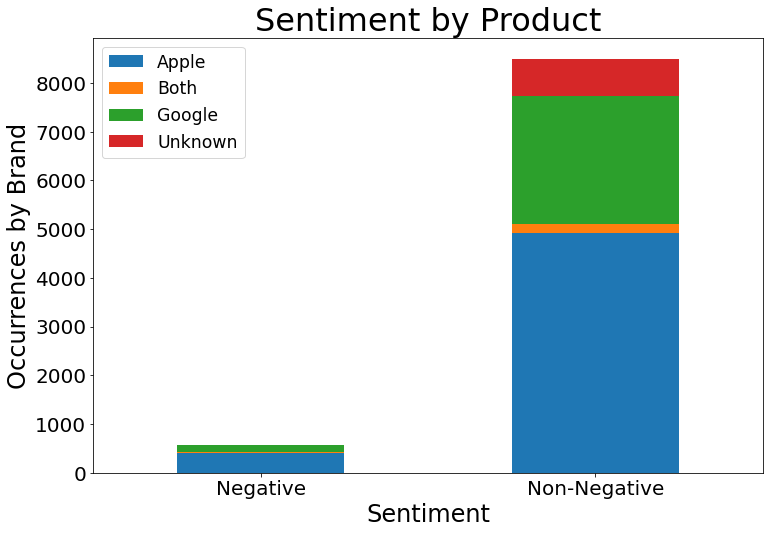

In [65]:
grouped = df.groupby(['Sentiment', 'Brand']).count()['Cleaned_Tweet']

fig = grouped.unstack().plot(kind='bar', stacked=True, align="center",figsize=(12,8))

fig.set_title('Sentiment by Product',fontsize=32)

fig.set_xlabel('Sentiment',fontsize=24)
fig.set_ylabel('Occurrences by Brand',fontsize=24)
fig.tick_params(labelsize=20)
plt.xticks(rotation=0)
fig.legend(loc='upper left', fontsize='xx-large');
# plt.savefig('Images/sentiment_bars')

<Figure size 1800x1080 with 0 Axes>

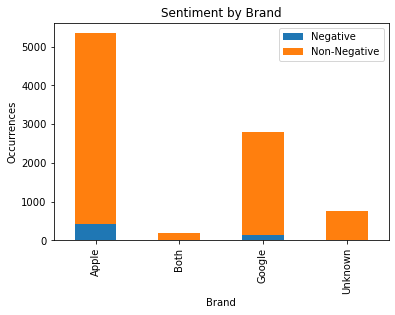

In [23]:
grouped = df.groupby(['Brand','Sentiment']).count()['Cleaned_Tweet']
plt.figure(figsize=(25, 15))
fig = grouped.unstack().plot(kind='bar', stacked=True, align="center")
fig.set_title('Sentiment by Brand')
fig.set_xlabel('Brand')
fig.set_ylabel('Occurrences')
fig.legend(loc='upper right');

In [24]:
X = df['Cleaned_Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
# vectorizer = CountVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)

In [26]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=200)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

In [27]:
# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,action,already,also,android,anyone,app,apple,apps,around,art,...,white,win,winning,wins,work,would,wow,year,yes,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.259208,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.231127,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.562686,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
6798,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
6799,0.0,0.0,0.0,0.0,0.0,0.0,0.264663,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.64206
6800,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000


# Modeling

### Baseline

In [28]:
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized, y_train)
baseline_model.score(X_train_vectorized, y_train)

0.9382534548662158

### RandomForest

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
rf.score(X_train_vectorized, y_train)

0.981182005292561

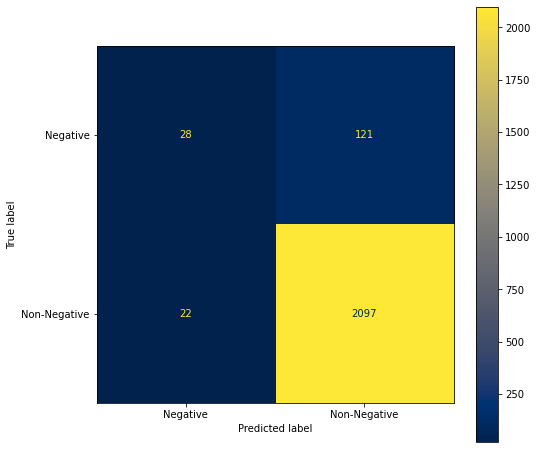

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(rf, X_test_vectorized, y_test, ax=ax, cmap="cividis");

In [31]:
y_pred_rf = rf.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_rf))

0.9369488536155203


### DecisionTree

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vectorized, y_train)
dt.score(X_train_vectorized, y_train)

0.981182005292561

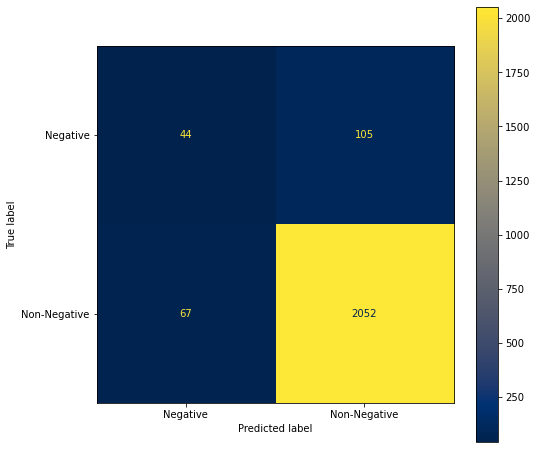

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(dt, X_test_vectorized, y_test, ax=ax, cmap="cividis");

In [34]:
y_pred_dt = dt.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_dt))

0.9241622574955908


### XGBoost

In [35]:
from xgboost import XGBClassifier

In [36]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train_vectorized, y_train)
xgb.score(X_train_vectorized, y_train)

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9539841223169656

In [37]:
y_pred_xgb = xgb.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_xgb))

0.9351851851851852
